# Assignment 3


Isaac Edem Adoboe - ieadoboe@mun.ca  
Masters, Data Science  
Student Number: 202384695


**ENVIRONMENT RULES**

![](grid_world.png){width=500px}

- Agent starts at BLUE SQUARE
- RED STATE = -20 and goes back to start (BLUE SQUARE)
- Move between any two other states = -1
- Move outside the grid = -1
- BLACK SQUARE -> terminal state -> episode terminates -> mission complete


## Environment setup


In [1]:
# import libraries
import jax.numpy as jnp
import numpy as np
from jax import jit, random
import matplotlib.pyplot as plt

In [2]:
# Grid dimensions and constants
GRID_SIZE = 5
N_STATES = GRID_SIZE * GRID_SIZE
N_ACTIONS = 4

# Action encoding
UP, DOWN, LEFT, RIGHT = 0, 1, 2, 3
ACTION_NAMES = ["Up", "Down", "Left", "Right"]

# State type encoding
EMPTY, TERMINAL, PENALTY, START = 0, 1, 2, 3

In [3]:
def coord_to_idx(row, col):
    return row * GRID_SIZE + col


def idx_to_coord(idx):
    return idx // GRID_SIZE, idx % GRID_SIZE


# create layout for grid world
# 1=terminal(black), 0=empty(white), 2=penalty(red), 3=start(blue)
def create_grid_layout():
    grid = jnp.array(
        [
            [1, 0, 0, 0, 1],
            [0, 0, 0, 0, 0],
            [2, 2, 0, 2, 2],
            [0, 0, 0, 0, 0],
            [3, 0, 0, 0, 0],
        ]
    )
    return grid


def get_special_states():
    """Get indices of special states"""
    grid = create_grid_layout()

    start_states = []
    terminal_states = []
    penalty_states = []

    for r in range(GRID_SIZE):
        for c in range(GRID_SIZE):
            idx = coord_to_idx(r, c)
            if grid[r, c] == START:
                start_states.append(idx)
            elif grid[r, c] == TERMINAL:
                terminal_states.append(idx)
            elif grid[r, c] == PENALTY:
                penalty_states.append(idx)

    return start_states[0], terminal_states, penalty_states


# Get special states
START_STATE, TERMINAL_STATES, PENALTY_STATES = get_special_states()
print(f"AGENT START STATE (BLUE SQUARE) INDEX: {START_STATE}")
print(f"TERMINAL STATES (FINISH LINE) INDICES: {TERMINAL_STATES}")
print(f"PENALTY STATES INDICES: {PENALTY_STATES}")

AGENT START STATE (BLUE SQUARE) INDEX: 20
TERMINAL STATES (FINISH LINE) INDICES: [0, 4]
PENALTY STATES INDICES: [10, 11, 13, 14]


In [4]:
# get next position (cordinate)
def get_next_position(row, col, action):
    """Get next position given current position and action"""
    if action == UP:
        new_row = max(0, row - 1)
        new_col = col
    elif action == DOWN:
        new_row = min(GRID_SIZE - 1, row + 1)
        new_col = col
    elif action == LEFT:
        new_row = row
        new_col = max(0, col - 1)
    elif action == RIGHT:
        new_row = row
        new_col = min(GRID_SIZE - 1, col + 1)
    else:
        new_row, new_col = row, col

    return new_row, new_col


def get_next_state(state, action):
    """Get next state given current state and action"""
    row, col = idx_to_coord(state)
    new_row, new_col = get_next_position(row, col, action)
    return coord_to_idx(new_row, new_col)


def get_reward(state, action, next_state):
    """Get immediate reward for transition"""
    if next_state in PENALTY_STATES:
        return -20.0
    elif state in TERMINAL_STATES:
        return 0.0
    else:
        return -1.0


def is_terminal(state):
    """Check if state is terminal"""
    return state in TERMINAL_STATES

## SARSA vs Q-learning

**SARSA (State-Action-Reward-State-Action)** is an on-policy algorithm that updates Q-values using the action actually taken by the current policy.

**Q-learning** is an off-policy algorithm that updates Q-values using the maximum Q-value for the next state, regardless of the action actually taken.

**Key Differences**

1. SARSA learns about the policy it's following, while Q-learning learns about the optimal policy regardless of behavior
2. Q-learning converges to optimal Q\* under certain conditions; SARSA converges to the Q-function of the policy being followed
3. SARSA is more conservative with dangerous actions during exploration; Q-learning can be more aggressive


### Q-table Operations


In [5]:
def create_q_table(init_value=0.0):
    """Create Q-table with flat indexing"""
    return jnp.full((N_STATES, N_ACTIONS), init_value)


def get_state_q_values(q_table, state):
    """Get Q-values for a specific state"""
    return q_table[state, :]

### Define Action Selection - $\epsilon$-greedy action


In [6]:
def epsilon_greedy_action(q_values, epsilon, key):
    """Select action using epsilon-greedy policy"""
    if random.uniform(key) < epsilon:
        return random.randint(key, shape=(), minval=0, maxval=N_ACTIONS)
    return jnp.argmax(q_values)


# def greedy_action(q_values):
#     """Select best action (greedy)"""
#     return jnp.argmax(q_values)


# def random_action(key):
#     """Select random action"""
#     return random.randint(key, shape=(), minval=0, maxval=N_ACTIONS)

### SARSA

$$Q(s,a) ← Q(s,a) + \alpha[r + \gamma Q(s',a') - Q(s,a)]$$

$\text{where, }$
$s$ - state, $a$ - action, $r$ - reward, $\gamma$ - discount factor, $\alpha$ - learning rate


In [7]:
@jit
def sarsa_update_jit(
    q_table, state, action, reward, next_state, next_action, alpha, gamma, done
):
    """SARSA update"""
    next_q_value = q_table[next_state, next_action]
    target = jnp.where(done, reward, reward + gamma * next_q_value)

    current_q = q_table[state, action]
    td_error = target - current_q
    new_q = current_q + alpha * td_error

    updated_q_table = q_table.at[state, action].set(new_q)
    return updated_q_table, td_error


def run_sarsa_episode(q_table, alpha, gamma, epsilon, key, max_steps=100):
    """Run single SARSA episode"""
    state = START_STATE
    trajectory = [state]
    total_reward = 0.0
    td_errors = []

    # SARSA: Choose initial action
    key, subkey = random.split(key)
    q_values = get_state_q_values(q_table, state)
    action = epsilon_greedy_action(q_values, epsilon, subkey)

    for _ in range(max_steps):
        # Take action
        next_state = get_next_state(state, action)
        reward = get_reward(state, action, next_state)
        total_reward += reward
        trajectory.append(next_state)
        done = is_terminal(next_state)

        if done:
            # Terminal update
            q_table, td_error = sarsa_update_jit(
                q_table, state, action, reward, next_state, 0, alpha, gamma, True
            )
            td_errors.append(float(td_error))
            break

        # Choose next action
        key, subkey = random.split(key)
        next_q_values = get_state_q_values(q_table, next_state)
        next_action = epsilon_greedy_action(next_q_values, epsilon, subkey)

        # SARSA update
        q_table, td_error = sarsa_update_jit(
            q_table, state, action, reward, next_state, next_action, alpha, gamma, False
        )
        td_errors.append(float(td_error))

        # Move to next state-action
        state = next_state
        action = next_action

    return q_table, trajectory, total_reward, td_errors, key


def train_sarsa(n_episodes, alpha=0.1, gamma=0.95, epsilon=0.1, seed=42):
    """Train SARSA algorithm"""
    key = random.PRNGKey(seed)
    q_table = create_q_table()

    rewards = []
    td_errors_history = []
    current_epsilon = epsilon

    for episode in range(n_episodes):
        key, subkey = random.split(key)
        q_table, trajectory, reward, td_errors, key = run_sarsa_episode(
            q_table, alpha, gamma, current_epsilon, subkey
        )

        rewards.append(reward)
        td_errors_history.append(td_errors)

        # Decay epsilon
        current_epsilon = max(0.01, current_epsilon * 0.995)

        if (episode + 1) % 100 == 0:
            recent_avg = jnp.mean(jnp.array(rewards[-100:]))
            print(f"SARSA Episode {episode + 1}: Recent avg reward = {recent_avg:.2f}")

    return q_table, rewards, td_errors_history

### Q-Learning

$$Q(s,a) ← Q(s,a) + \alpha[r + \gamma max Q(s',a') - Q(s,a)]$$

$\text{where, }$
$s$ - state, $a$ - action, $r$ - reward, $\gamma$ - discount factor, $\alpha$ - learning rate


In [8]:
@jit
def q_learning_update_jit(
    q_table, state, action, reward, next_state, alpha, gamma, done
):
    """Q-learning update"""
    max_next_q = jnp.max(q_table[next_state, :])
    target = jnp.where(done, reward, reward + gamma * max_next_q)

    current_q = q_table[state, action]
    td_error = target - current_q
    new_q = current_q + alpha * td_error

    updated_q_table = q_table.at[state, action].set(new_q)
    return updated_q_table, td_error


def run_q_learning_episode(q_table, alpha, gamma, epsilon, key, max_steps=100):
    """Run single Q-learning episode"""
    state = START_STATE
    trajectory = [state]
    total_reward = 0.0
    td_errors = []

    for _ in range(max_steps):
        # Choose action
        key, subkey = random.split(key)
        q_values = get_state_q_values(q_table, state)
        action = epsilon_greedy_action(q_values, epsilon, subkey)

        # Take action
        next_state = get_next_state(state, action)
        reward = get_reward(state, action, next_state)
        total_reward += reward
        trajectory.append(next_state)
        done = is_terminal(next_state)

        # Q-learning update
        q_table, td_error = q_learning_update_jit(
            q_table, state, action, reward, next_state, alpha, gamma, done
        )
        td_errors.append(float(td_error))

        if done:
            break

        state = next_state

    return q_table, trajectory, total_reward, td_errors, key


def train_q_learning(n_episodes, alpha=0.1, gamma=0.95, epsilon=0.1, seed=42):
    """Train Q-learning algorithm"""
    key = random.PRNGKey(seed)
    q_table = create_q_table()

    rewards = []
    td_errors_history = []
    current_epsilon = epsilon

    for episode in range(n_episodes):
        key, subkey = random.split(key)
        q_table, trajectory, reward, td_errors, key = run_q_learning_episode(
            q_table, alpha, gamma, current_epsilon, subkey
        )

        rewards.append(reward)
        td_errors_history.append(td_errors)

        # Decay epsilon
        current_epsilon = max(0.01, current_epsilon * 0.995)

        if (episode + 1) % 100 == 0:
            recent_avg = jnp.mean(jnp.array(rewards[-100:]))
            print(
                f"Q-Learning Episode {episode + 1}: Recent avg reward = {recent_avg:.2f}"
            )

    return q_table, rewards, td_errors_history

### Policy Extraction and Analysis


In [9]:
def trajectory_to_coords(trajectory):
    """Convert trajectory of state indices to coordinates"""
    return [idx_to_coord(state) for state in trajectory]

### Run SARSA simulations


In [10]:
def extract_sarsa_policy(q_table, epsilon=0.01):
    """Extract epsilon-greedy policy from SARSA Q-table"""
    if epsilon == 0.0:
        return jnp.argmax(q_table, axis=1)
    else:
        # Return greedy policy as approximation
        # (True SARSA policy is stochastic epsilon-greedy)
        return jnp.argmax(q_table, axis=1)


def get_sarsa_trajectory(q_table, epsilon=0.01, max_steps=20, key=None):
    """Get trajectory following SARSA epsilon-greedy policy"""
    if key is None:
        key = random.PRNGKey(42)

    state = START_STATE
    trajectory = [state]

    for _ in range(max_steps):
        if is_terminal(state):
            break

        q_values = get_state_q_values(q_table, state)

        if epsilon == 0.0:
            action = int(jnp.argmax(q_values))
        else:
            key, subkey = random.split(key)
            action = int(epsilon_greedy_action(q_values, epsilon, subkey))

        state = get_next_state(state, action)
        trajectory.append(state)

    return trajectory


# def compute_sarsa_state_values(q_table, epsilon=0.01):
#     """Compute SARSA state values V^π_ε(s)"""
#     if epsilon == 0.0:
#         return jnp.max(q_table, axis=1)
#     else:
#         # True epsilon-greedy value function
#         n_actions = q_table.shape[1]
#         max_q = jnp.max(q_table, axis=1)
#         avg_q = jnp.mean(q_table, axis=1)
#         return (1 - epsilon) * max_q + epsilon * avg_q

In [11]:
def run_sarsa_experiment(n_episodes=1000, alpha=0.1, gamma=0.95, epsilon=0.1, seed=42):
    print(
        f"\nTraining {n_episodes} episodes with learning rate={alpha}, discount factor={gamma}, epsilon={epsilon}"
    )

    # Train both algorithms
    print("\n=== Training SARSA ===")
    q_table_sarsa, rewards_sarsa, td_errors_sarsa = train_sarsa(
        n_episodes, alpha, gamma, epsilon, seed
    )

    # Analysis
    print("\n=== Analysis ===")
    traj_sarsa = get_sarsa_trajectory(q_table_sarsa)

    print(f"SARSA trajectory (states): {traj_sarsa}")
    print(f"SARSA trajectory (coords): {trajectory_to_coords(traj_sarsa)}")

    return q_table_sarsa, rewards_sarsa


q_table_sarsa, rewards_sarsa = run_sarsa_experiment()


Training 1000 episodes with learning rate=0.1, discount factor=0.95, epsilon=0.1

=== Training SARSA ===
SARSA Episode 100: Recent avg reward = -34.18
SARSA Episode 200: Recent avg reward = -12.47
SARSA Episode 300: Recent avg reward = -9.45
SARSA Episode 400: Recent avg reward = -9.34
SARSA Episode 500: Recent avg reward = -8.26
SARSA Episode 600: Recent avg reward = -8.30
SARSA Episode 700: Recent avg reward = -8.12
SARSA Episode 800: Recent avg reward = -8.09
SARSA Episode 900: Recent avg reward = -8.25
SARSA Episode 1000: Recent avg reward = -8.03

=== Analysis ===
SARSA trajectory (states): [20, 21, 22, 17, 12, 7, 2, 3, 4]
SARSA trajectory (coords): [(4, 0), (4, 1), (4, 2), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 4)]


### Run Q-learning simulations


In [12]:
def extract_q_learning_policy(q_table):
    """Extract optimal policy from Q-learning Q-table"""
    return jnp.argmax(q_table, axis=1)


def get_q_learning_trajectory(q_table, max_steps=20):
    """Get trajectory following Q-learning optimal policy"""
    state = START_STATE
    trajectory = [state]

    for _ in range(max_steps):
        if is_terminal(state):
            break

        q_values = get_state_q_values(q_table, state)
        action = int(jnp.argmax(q_values))
        state = get_next_state(state, action)
        trajectory.append(state)

    return trajectory


# def compute_q_learning_state_values(q_table):
#     """Compute optimal state values V*(s) = max_a Q*(s,a)"""
#     return jnp.max(q_table, axis=1)

In [13]:
def run_qlearning_experiment(
    n_episodes=1000, alpha=0.1, gamma=0.95, epsilon=0.1, seed=42
):
    print(
        f"\nTraining {n_episodes} episodes with learning rate={alpha}, discount factor={gamma}, epsilon={epsilon}"
    )

    # Train Q-learning algorithms
    print("\n=== Training Q-Learning ===")
    q_table_qlearning, rewards_qlearning, td_errors_qlearning = train_q_learning(
        n_episodes, alpha, gamma, epsilon, seed
    )

    # Analysis
    print("\n=== Analysis ===")
    traj_qlearning = get_q_learning_trajectory(q_table_qlearning)

    print(f"Q-Learning trajectory (states): {traj_qlearning}")
    print(f"Q-Learning trajectory (coords): {trajectory_to_coords(traj_qlearning)}")

    return q_table_qlearning, rewards_qlearning


q_table_qlearning, rewards_qlearning = run_qlearning_experiment()


Training 1000 episodes with learning rate=0.1, discount factor=0.95, epsilon=0.1

=== Training Q-Learning ===
Q-Learning Episode 100: Recent avg reward = -34.26
Q-Learning Episode 200: Recent avg reward = -12.52
Q-Learning Episode 300: Recent avg reward = -10.05
Q-Learning Episode 400: Recent avg reward = -8.96
Q-Learning Episode 500: Recent avg reward = -8.56
Q-Learning Episode 600: Recent avg reward = -8.22
Q-Learning Episode 700: Recent avg reward = -8.28
Q-Learning Episode 800: Recent avg reward = -8.23
Q-Learning Episode 900: Recent avg reward = -8.54
Q-Learning Episode 1000: Recent avg reward = -8.30

=== Analysis ===
Q-Learning trajectory (states): [20, 15, 16, 17, 12, 7, 2, 1, 0]
Q-Learning trajectory (coords): [(4, 0), (3, 0), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 1), (0, 0)]


In [14]:
# Analysis
print("\n=== Final Analysis ===")
traj_sarsa = get_sarsa_trajectory(q_table_sarsa)
traj_qlearning = get_q_learning_trajectory(q_table_qlearning)

print(f"SARSA trajectory (states): {traj_sarsa}")
print(f"SARSA trajectory (coords): {trajectory_to_coords(traj_sarsa)}")
print(f"Q-Learning trajectory (states): {traj_qlearning}")
print(f"Q-Learning trajectory (coords): {trajectory_to_coords(traj_qlearning)}")

# Final performance
sarsa_final = jnp.mean(jnp.array(rewards_sarsa[-50:]))
qlearning_final = jnp.mean(jnp.array(rewards_qlearning[-50:]))
print(f"SARSA final avg reward: {sarsa_final:.2f}")
print(f"Q-Learning final avg reward: {qlearning_final:.2f}")


=== Final Analysis ===
SARSA trajectory (states): [20, 21, 22, 17, 12, 7, 2, 3, 4]
SARSA trajectory (coords): [(4, 0), (4, 1), (4, 2), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 4)]
Q-Learning trajectory (states): [20, 15, 16, 17, 12, 7, 2, 1, 0]
Q-Learning trajectory (coords): [(4, 0), (3, 0), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 1), (0, 0)]
SARSA final avg reward: -8.02
Q-Learning final avg reward: -8.08


## Visualization


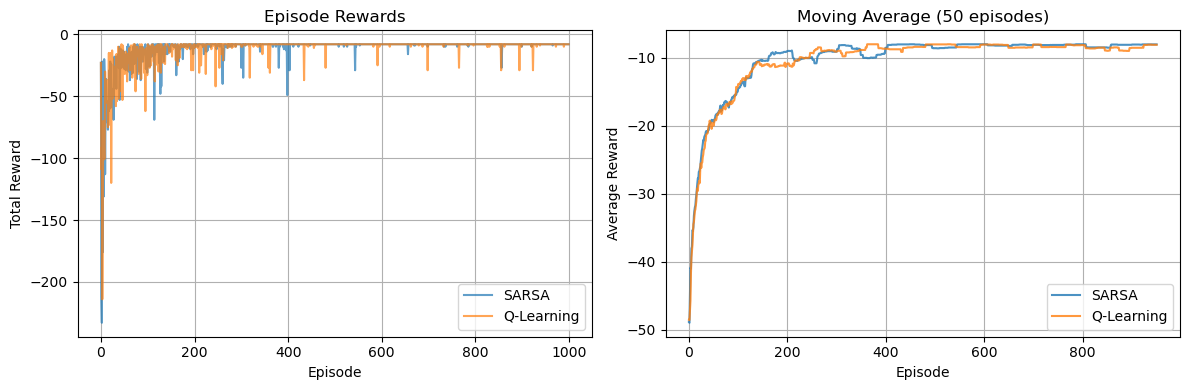

In [15]:
def plot_learning_curves(rewards_sarsa, rewards_qlearning):
    """Plot learning curves"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Raw rewards
    axes[0].plot(rewards_sarsa, label="SARSA", alpha=0.7)
    axes[0].plot(rewards_qlearning, label="Q-Learning", alpha=0.7)
    axes[0].set_title("Episode Rewards")
    axes[0].set_xlabel("Episode")
    axes[0].set_ylabel("Total Reward")
    axes[0].legend()
    axes[0].grid(True)

    # Moving average
    window = 50
    if len(rewards_sarsa) > window:
        sarsa_smooth = jnp.convolve(
            jnp.array(rewards_sarsa), jnp.ones(window) / window, mode="valid"
        )
        qlearn_smooth = jnp.convolve(
            jnp.array(rewards_qlearning), jnp.ones(window) / window, mode="valid"
        )

        axes[1].plot(sarsa_smooth, label="SARSA", alpha=0.8)
        axes[1].plot(qlearn_smooth, label="Q-Learning", alpha=0.8)
        axes[1].set_title(f"Moving Average ({window} episodes)")
        axes[1].set_xlabel("Episode")
        axes[1].set_ylabel("Average Reward")
        axes[1].legend()
        axes[1].grid(True)

    plt.tight_layout()
    plt.show()


plot_learning_curves(rewards_sarsa, rewards_qlearning)

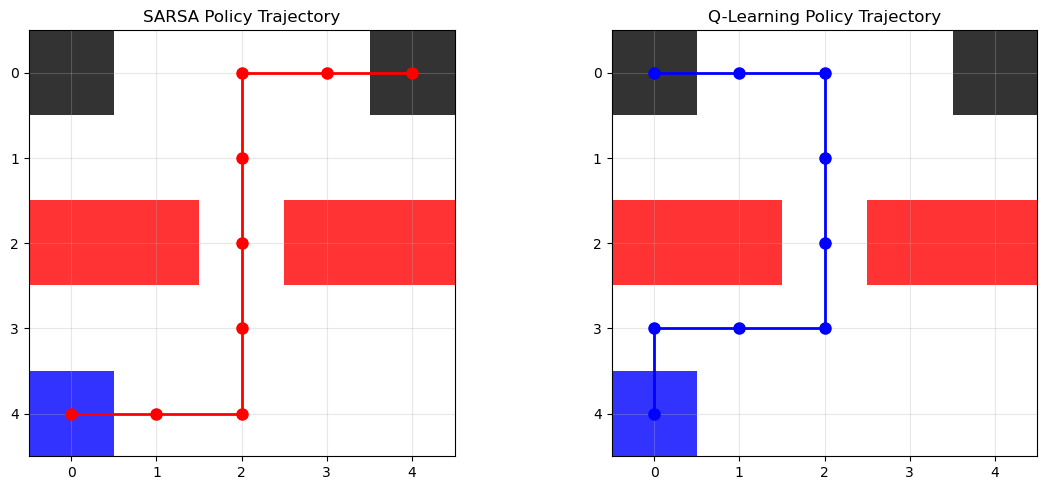

In [19]:
def plot_trajectories_and_policies(q_table_sarsa, q_table_qlearning):
    from matplotlib.colors import ListedColormap

    grid = create_grid_layout()

    # Create custom colormap: 0=white(regular), 1=black(terminal), 2=red(penalty), 3=blue(start)
    colors = ["white", "black", "red", "blue"]
    custom_cmap = ListedColormap(colors)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Get trajectories
    traj_sarsa = get_sarsa_trajectory(q_table_sarsa)
    traj_qlearning = get_q_learning_trajectory(q_table_qlearning)

    # Convert to coordinates
    coords_sarsa = trajectory_to_coords(traj_sarsa)
    coords_qlearning = trajectory_to_coords(traj_qlearning)

    # Plot SARSA
    axes[0].imshow(grid, cmap=custom_cmap, alpha=0.8)
    if len(coords_sarsa) > 1:
        coords_array = np.array(coords_sarsa)
        axes[0].plot(
            coords_array[:, 1], coords_array[:, 0], "ro-", linewidth=2, markersize=8
        )
    axes[0].set_title("SARSA Policy Trajectory")
    axes[0].set_xticks(range(GRID_SIZE))
    axes[0].set_yticks(range(GRID_SIZE))
    axes[0].grid(True, alpha=0.3)

    # Plot Q-Learning
    axes[1].imshow(grid, cmap=custom_cmap, alpha=0.8)
    if len(coords_qlearning) > 1:
        coords_array = np.array(coords_qlearning)
        axes[1].plot(
            coords_array[:, 1], coords_array[:, 0], "bo-", linewidth=2, markersize=8
        )
    axes[1].set_title("Q-Learning Policy Trajectory")
    axes[1].set_xticks(range(GRID_SIZE))
    axes[1].set_yticks(range(GRID_SIZE))
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_trajectories_and_policies(q_table_sarsa, q_table_qlearning)